Loading 20 Newsgroups dataset...
Number of documents: 18846
Number of categories: 20
Documents after filtering (len > 50 words): 12753
Preparing data for LDA...

Training LDA model...

Training BERTopic model...


2026-01-16 21:02:04,142 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/399 [00:00<?, ?it/s]

2026-01-16 21:09:15,830 - BERTopic - Embedding - Completed ✓
2026-01-16 21:09:15,830 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-16 21:09:19,124 - BERTopic - Dimensionality - Completed ✓
2026-01-16 21:09:19,129 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-16 21:09:25,799 - BERTopic - Cluster - Completed ✓
2026-01-16 21:09:25,849 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-16 21:09:28,843 - BERTopic - Representation - Completed ✓


BERTopic identified 123 topics (excluding outliers)
CALCULATING CORE METRICS

Calculating Coherence Scores...
LDA Coherence (C_v): 0.4522
BERTopic Coherence (C_v): 0.6815

Calculating Topic Diversity...
LDA Topic Diversity: 0.6267
BERTopic Topic Diversity: 0.7577

Calculating Topic Distinctiveness...
LDA Topic Distinctiveness: 0.9143
BERTopic Topic Distinctiveness: 0.9946

Calculating Jaccard Similarity Matrices...

LDA Average Jaccard Similarity (excluding diagonal): 0.0857
BERTopic Average Jaccard Similarity (excluding diagonal): 0.0054
CREATING COMPREHENSIVE VISUALIZATION


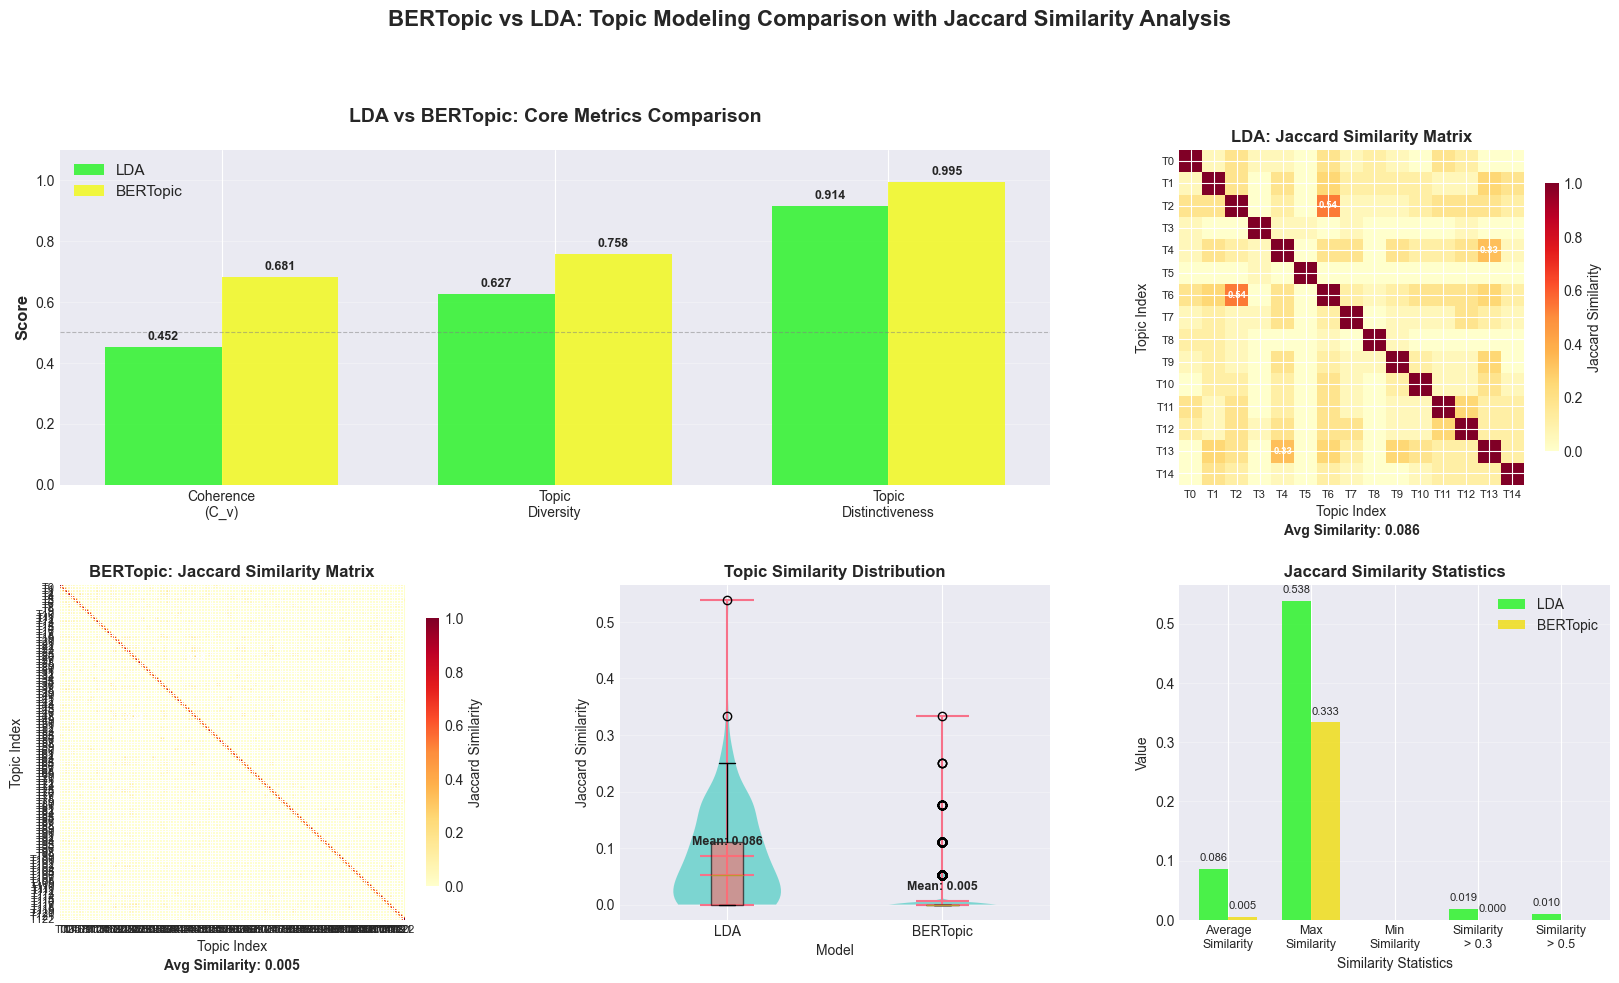

METRICS SUMMARY TABLE

                    Metric    LDA BERTopic
           Coherence (C_v) 0.4522   0.6815
           Topic Diversity 0.6267   0.7577
     Topic Distinctiveness 0.9143   0.9946
Average Jaccard Similarity 0.0857   0.0054
DETAILED JACCARD MATRIX ANALYSIS

LDA Highly Similar Topic Pairs (similarity > 0.3):
  Topics 2 & 6: similarity = 0.538
    Common words: from, were, by
  Topics 4 & 13: similarity = 0.333
    Common words: or

BERTopic Highly Similar Topic Pairs (similarity > 0.3):
  Topics 26 & 48: similarity = 0.333
    Common words: mr, stephanopoulos
SAVING RESULTS


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import CoherenceModel, LdaModel
from gensim.corpora import Dictionary
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# 1. Load the 20 Newsgroups dataset

print("Loading 20 Newsgroups dataset...")

newsgroups = fetch_20newsgroups(subset='all', 
                                 remove=('headers', 'footers', 'quotes'),
                                 shuffle=True, 
                                 random_state=42)

documents = newsgroups.data
true_labels = newsgroups.target
print(f"Number of documents: {len(documents)}")
print(f"Number of categories: {len(newsgroups.target_names)}")

# Filter out very short documents
min_length = 50
filtered_docs = [doc for doc in documents if len(doc.split()) > min_length]
print(f"Documents after filtering (len > {min_length} words): {len(filtered_docs)}")

# 2. Preprocessing function
def preprocess(text):
    """Basic text preprocessing"""
    text = text.lower()
    # Remove special characters and digits
    text = ''.join([char for char in text if char.isalpha() or char.isspace()])
    return text

preprocessed_docs = [preprocess(doc) for doc in filtered_docs]

# 3. Prepare data for LDA

print("Preparing data for LDA...")

vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
X = vectorizer.fit_transform(preprocessed_docs)
feature_names = vectorizer.get_feature_names_out()

# Create gensim corpus
tokenized_docs = [doc.split() for doc in preprocessed_docs]
dictionary = Dictionary(tokenized_docs)
# Filter extremes
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

# 4. Train LDA model
print("\nTraining LDA model...")
num_topics = 15  # Same as number of categories in 20 Newsgroups
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=num_topics,
                     random_state=42,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)

# 5. Train BERTopic model
print("\nTraining BERTopic model...")
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
bertopic_model = BERTopic(embedding_model=sentence_model,
                          min_topic_size=15,
                          language='english',
                          calculate_probabilities=True,
                          verbose=True)

bertopic_topics, bertopic_probs = bertopic_model.fit_transform(filtered_docs)

# Get BERTopic topics (excluding outliers)
bertopic_topic_nums = sorted([t for t in set(bertopic_topics) if t != -1])
print(f"BERTopic identified {len(bertopic_topic_nums)} topics (excluding outliers)")

# 6. Get Topic Representations
def get_topic_words(model_type, model, n_words=15):
    """Get topic words for both models"""
    if model_type == 'lda':
        topic_words = []
        for i in range(num_topics):
            topic = model.show_topic(i, topn=n_words)
            words = [word for word, _ in topic]
            topic_words.append(words)
        return topic_words
    else:  # bertopic
        topic_words = []
        for topic_num in bertopic_topic_nums:
            if topic_num in bertopic_model.get_topics():
                words = [word for word, _ in bertopic_model.get_topic(topic_num)[:n_words]]
                topic_words.append(words)
        return topic_words

lda_topic_words = get_topic_words('lda', lda_model)
bertopic_topic_words = get_topic_words('bertopic', bertopic_model)

# 7. METRIC CALCULATION FUNCTIONS

def calculate_coherence(model_type, model, topic_words=None):
    """Calculate C_v coherence score"""
    if model_type == 'lda':
        coherence_model = CoherenceModel(model=model,
                                         texts=tokenized_docs,
                                         dictionary=dictionary,
                                         coherence='c_v')
        return coherence_model.get_coherence()
    else:  # bertopic
        coherence_model = CoherenceModel(topics=topic_words,
                                         texts=tokenized_docs,
                                         dictionary=dictionary,
                                         coherence='c_v')
        return coherence_model.get_coherence()

def calculate_topic_diversity(topic_words, top_n=10):
    """Calculate topic diversity - proportion of unique words across topics"""
    all_words = []
    for words in topic_words:
        all_words.extend(words[:top_n])
    
    unique_words = set(all_words)
    diversity = len(unique_words) / len(all_words) if len(all_words) > 0 else 0
    return diversity

def calculate_topic_distinctiveness(topic_words, top_n=10):
    """Calculate topic distinctiveness using pairwise Jaccard similarity"""
    n_topics = len(topic_words)
    if n_topics <= 1:
        return 1.0
    
    similarities = []
    for i in range(n_topics):
        words_i = set(topic_words[i][:top_n])
        for j in range(i + 1, n_topics):
            words_j = set(topic_words[j][:top_n])
            # Jaccard similarity
            intersection = len(words_i.intersection(words_j))
            union = len(words_i.union(words_j))
            similarity = intersection / union if union > 0 else 0
            similarities.append(similarity)
    
    if similarities:
        avg_similarity = np.mean(similarities)
        distinctiveness = 1 - avg_similarity
    else:
        distinctiveness = 1.0
    
    return distinctiveness

def calculate_jaccard_matrix(topic_words, top_n=10):
    """Calculate Jaccard similarity matrix for topics"""
    n_topics = len(topic_words)
    jaccard_matrix = np.zeros((n_topics, n_topics))
    
    for i in range(n_topics):
        words_i = set(topic_words[i][:top_n])
        for j in range(n_topics):
            if i == j:
                jaccard_matrix[i, j] = 1.0  # Diagonal = 1 (self-similarity)
            else:
                words_j = set(topic_words[j][:top_n])
                intersection = len(words_i.intersection(words_j))
                union = len(words_i.union(words_j))
                jaccard_matrix[i, j] = intersection / union if union > 0 else 0
    
    return jaccard_matrix

# 8. Calculate Core Metrics

print("CALCULATING CORE METRICS")


# Coherence
print("\nCalculating Coherence Scores...")
lda_coherence = calculate_coherence('lda', lda_model)
bertopic_coherence = calculate_coherence('bertopic', None, bertopic_topic_words)
print(f"LDA Coherence (C_v): {lda_coherence:.4f}")
print(f"BERTopic Coherence (C_v): {bertopic_coherence:.4f}")

# Topic Diversity
print("\nCalculating Topic Diversity...")
lda_diversity = calculate_topic_diversity(lda_topic_words)
bertopic_diversity = calculate_topic_diversity(bertopic_topic_words)
print(f"LDA Topic Diversity: {lda_diversity:.4f}")
print(f"BERTopic Topic Diversity: {bertopic_diversity:.4f}")

# Topic Distinctiveness
print("\nCalculating Topic Distinctiveness...")
lda_distinctiveness = calculate_topic_distinctiveness(lda_topic_words)
bertopic_distinctiveness = calculate_topic_distinctiveness(bertopic_topic_words)
print(f"LDA Topic Distinctiveness: {lda_distinctiveness:.4f}")
print(f"BERTopic Topic Distinctiveness: {bertopic_distinctiveness:.4f}")

# Jaccard Similarity Matrices
print("\nCalculating Jaccard Similarity Matrices...")
lda_jaccard_matrix = calculate_jaccard_matrix(lda_topic_words)
bertopic_jaccard_matrix = calculate_jaccard_matrix(bertopic_topic_words)

# Calculate average similarity (excluding diagonal)
def calculate_average_similarity(matrix):
    """Calculate average similarity excluding diagonal"""
    n = matrix.shape[0]
    if n <= 1:
        return 0
    # Get upper triangle excluding diagonal
    upper_tri = matrix[np.triu_indices_from(matrix, k=1)]
    return np.mean(upper_tri) if len(upper_tri) > 0 else 0

lda_avg_similarity = calculate_average_similarity(lda_jaccard_matrix)
bertopic_avg_similarity = calculate_average_similarity(bertopic_jaccard_matrix)

print(f"\nLDA Average Jaccard Similarity (excluding diagonal): {lda_avg_similarity:.4f}")
print(f"BERTopic Average Jaccard Similarity (excluding diagonal): {bertopic_avg_similarity:.4f}")

# 9. Create Comprehensive Visualization

print("CREATING COMPREHENSIVE VISUALIZATION")


# Create figure with GridSpec for better layout
fig = plt.figure(figsize=(20, 10))
gs = GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)

# 1. MODEL COMPARISON CHART (Spans 2 columns)
ax1 = fig.add_subplot(gs[0, :2])  # Top row, first 2 columns

# Prepare data for grouped bar chart
metrics = ['Coherence\n(C_v)', 'Topic\nDiversity', 'Topic\nDistinctiveness']
lda_scores = [lda_coherence, lda_diversity, lda_distinctiveness]
bertopic_scores = [bertopic_coherence, bertopic_diversity, bertopic_distinctiveness]

x = np.arange(len(metrics))
width = 0.35

# Create grouped bars
bars1 = ax1.bar(x - width/2, lda_scores, width, label='LDA', color="#22F31F", alpha=0.8)
bars2 = ax1.bar(x + width/2, bertopic_scores, width, label='BERTopic', color="#F2FA11F6", alpha=0.8)

# Add value labels on top of bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

autolabel(bars1)
autolabel(bars2)

# Customize the chart
ax1.set_ylabel('Score', fontsize=12, fontweight='bold')
ax1.set_title('LDA vs BERTopic: Core Metrics Comparison', 
              fontsize=14, fontweight='bold', pad=20)
ax1.set_xticks(x)
ax1.set_xticklabels(metrics, fontsize=10, rotation=0, ha='center')
ax1.legend(loc='upper left', fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim([0, 1.1])

# Add horizontal lines for reference
#ax1.axhline(y=0.7, color='gray', linestyle='--', alpha=0.5, linewidth=0.8)
ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, linewidth=0.8)
#ax1.text(len(metrics)-0.5, 0.72, 'Good', fontsize=9, alpha=0.7, ha='right')
#ax1.text(len(metrics)-0.5, 0.52, 'Average', fontsize=9, alpha=0.7, ha='right')

# 2. LDA JACCARD SIMILARITY MATRIX HEATMAP
ax2 = fig.add_subplot(gs[0, 2])  # Top row, third column

# Create heatmap for LDA
im1 = ax2.imshow(lda_jaccard_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
ax2.set_title('LDA: Jaccard Similarity Matrix', fontsize=12, fontweight='bold')
ax2.set_xlabel('Topic Index', fontsize=10)
ax2.set_ylabel('Topic Index', fontsize=10)
ax2.set_xticks(np.arange(len(lda_topic_words)))
ax2.set_yticks(np.arange(len(lda_topic_words)))
ax2.set_xticklabels([f'T{i}' for i in range(len(lda_topic_words))], fontsize=8)
ax2.set_yticklabels([f'T{i}' for i in range(len(lda_topic_words))], fontsize=8)

# Add colorbar
cbar1 = fig.colorbar(im1, ax=ax2, shrink=0.8)
cbar1.set_label('Jaccard Similarity', fontsize=10)

# Add text annotations for significant similarities (> 0.3)
for i in range(len(lda_topic_words)):
    for j in range(len(lda_topic_words)):
        if i != j and lda_jaccard_matrix[i, j] > 0.3:
            text = ax2.text(j, i, f'{lda_jaccard_matrix[i, j]:.2f}',
                           ha="center", va="center", color="white", fontsize=7, fontweight='bold')

# Annotate average similarity
ax2.text(0.5, -0.15, f'Avg Similarity: {lda_avg_similarity:.3f}', 
         transform=ax2.transAxes, ha='center', fontsize=10, fontweight='bold')

# 3. BERTOPIC JACCARD SIMILARITY MATRIX HEATMAP
ax3 = fig.add_subplot(gs[1, 0])  # Bottom row, first column

# Create heatmap for BERTopic
im2 = ax3.imshow(bertopic_jaccard_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
ax3.set_title('BERTopic: Jaccard Similarity Matrix', fontsize=12, fontweight='bold')
ax3.set_xlabel('Topic Index', fontsize=10)
ax3.set_ylabel('Topic Index', fontsize=10)
ax3.set_xticks(np.arange(len(bertopic_topic_words)))
ax3.set_yticks(np.arange(len(bertopic_topic_words)))
ax3.set_xticklabels([f'T{i}' for i in range(len(bertopic_topic_words))], fontsize=8)
ax3.set_yticklabels([f'T{i}' for i in range(len(bertopic_topic_words))], fontsize=8)

# Add colorbar
cbar2 = fig.colorbar(im2, ax=ax3, shrink=0.8)
cbar2.set_label('Jaccard Similarity', fontsize=10)

# Add text annotations for significant similarities (> 0.3)
for i in range(len(bertopic_topic_words)):
    for j in range(len(bertopic_topic_words)):
        if i != j and bertopic_jaccard_matrix[i, j] > 0.3:
            text = ax3.text(j, i, f'{bertopic_jaccard_matrix[i, j]:.2f}',
                           ha="center", va="center", color="white", fontsize=7, fontweight='bold')

# Annotate average similarity
ax3.text(0.5, -0.15, f'Avg Similarity: {bertopic_avg_similarity:.3f}', 
         transform=ax3.transAxes, ha='center', fontsize=10, fontweight='bold')

# 4. TOPIC SIMILARITY DISTRIBUTION COMPARISON
ax4 = fig.add_subplot(gs[1, 1])

# Get similarity values (excluding diagonals)
lda_similarities = lda_jaccard_matrix[np.triu_indices_from(lda_jaccard_matrix, k=1)]
bertopic_similarities = bertopic_jaccard_matrix[np.triu_indices_from(bertopic_jaccard_matrix, k=1)]

# Create violin plot
positions = [1, 2]
data = [lda_similarities, bertopic_similarities]
violin_parts = ax4.violinplot(data, positions=positions, showmeans=True, showmedians=True)

# Customize violin colors
for pc in violin_parts['bodies']:
    pc.set_facecolor('#4ECDC4')
    pc.set_alpha(0.7)

# Add box plot inside
box_parts = ax4.boxplot(data, positions=positions, widths=0.15, patch_artist=True)
for box in box_parts['boxes']:
    box.set_facecolor('#FF6B6B')
    box.set_alpha(0.6)

# Customize the plot
ax4.set_xlabel('Model', fontsize=10)
ax4.set_ylabel('Jaccard Similarity', fontsize=10)
ax4.set_title('Topic Similarity Distribution', fontsize=12, fontweight='bold')
ax4.set_xticks(positions)
ax4.set_xticklabels(['LDA', 'BERTopic'])
ax4.grid(True, alpha=0.3, axis='y')

# Add mean values
ax4.text(1, np.mean(lda_similarities) + 0.02, f'Mean: {np.mean(lda_similarities):.3f}', 
         ha='center', fontsize=9, fontweight='bold')
ax4.text(2, np.mean(bertopic_similarities) + 0.02, f'Mean: {np.mean(bertopic_similarities):.3f}', 
         ha='center', fontsize=9, fontweight='bold')

# 5. SIMILARITY STATISTICS COMPARISON
ax5 = fig.add_subplot(gs[1, 2])

# Prepare statistics data
statistics = ['Average\nSimilarity', 'Max\nSimilarity', 'Min\nSimilarity', 
              'Similarity\n> 0.3', 'Similarity\n> 0.5']

lda_stats = [
    lda_avg_similarity,
    np.max(lda_similarities) if len(lda_similarities) > 0 else 0,
    np.min(lda_similarities) if len(lda_similarities) > 0 else 0,
    np.sum(lda_similarities > 0.3) / len(lda_similarities) if len(lda_similarities) > 0 else 0,
    np.sum(lda_similarities > 0.5) / len(lda_similarities) if len(lda_similarities) > 0 else 0
]

bertopic_stats = [
    bertopic_avg_similarity,
    np.max(bertopic_similarities) if len(bertopic_similarities) > 0 else 0,
    np.min(bertopic_similarities) if len(bertopic_similarities) > 0 else 0,
    np.sum(bertopic_similarities > 0.3) / len(bertopic_similarities) if len(bertopic_similarities) > 0 else 0,
    np.sum(bertopic_similarities > 0.5) / len(bertopic_similarities) if len(bertopic_similarities) > 0 else 0
]

x = np.arange(len(statistics))
width = 0.35

bars3 = ax5.bar(x - width/2, lda_stats, width, label='LDA', color='#22F31F', alpha=0.8)
bars4 = ax5.bar(x + width/2, bertopic_stats, width, label='BERTopic', color='#F0DD0C', alpha=0.8)

# Add value labels
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Only add labels for non-zero heights
            ax5.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=8)

ax5.set_xlabel('Similarity Statistics', fontsize=10)
ax5.set_ylabel('Value', fontsize=10)
ax5.set_title('Jaccard Similarity Statistics', fontsize=12, fontweight='bold')
ax5.set_xticks(x)
ax5.set_xticklabels(statistics, fontsize=9, rotation=0, ha='center')
ax5.legend(loc='upper right')
ax5.grid(True, alpha=0.3, axis='y')

plt.suptitle('BERTopic vs LDA: Topic Modeling Comparison with Jaccard Similarity Analysis', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('model_comparison_jaccard_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# 10. Create Metrics Summary Table

print("METRICS SUMMARY TABLE")


metrics_summary = pd.DataFrame({
    'Metric': [
        'Coherence (C_v)',
        'Topic Diversity',
        'Topic Distinctiveness',
        'Average Jaccard Similarity'
    ],
    'LDA': [
        f"{lda_coherence:.4f}",
        f"{lda_diversity:.4f}",
        f"{lda_distinctiveness:.4f}",
        f"{lda_avg_similarity:.4f}"
    ],
    'BERTopic': [
        f"{bertopic_coherence:.4f}",
        f"{bertopic_diversity:.4f}",
        f"{bertopic_distinctiveness:.4f}",
        f"{bertopic_avg_similarity:.4f}"
    ]
})

print("\n" + metrics_summary.to_string(index=False))

# 11. Detailed Jaccard Matrix Analysis

print("DETAILED JACCARD MATRIX ANALYSIS")


# Find highly similar topic pairs for each model
def find_highly_similar_pairs(matrix, topic_words, threshold=0.3):
    """Find topic pairs with similarity above threshold"""
    similar_pairs = []
    n = len(matrix)
    for i in range(n):
        for j in range(i + 1, n):
            if matrix[i, j] > threshold:
                similar_pairs.append({
                    'topic_i': i,
                    'topic_j': j,
                    'similarity': matrix[i, j],
                    'common_words': set(topic_words[i][:5]) & set(topic_words[j][:5])
                })
    return similar_pairs

print("\nLDA Highly Similar Topic Pairs (similarity > 0.3):")
lda_similar_pairs = find_highly_similar_pairs(lda_jaccard_matrix, lda_topic_words, 0.3)
if lda_similar_pairs:
    for pair in sorted(lda_similar_pairs, key=lambda x: x['similarity'], reverse=True)[:5]:
        print(f"  Topics {pair['topic_i']} & {pair['topic_j']}: similarity = {pair['similarity']:.3f}")
        if pair['common_words']:
            print(f"    Common words: {', '.join(pair['common_words'])}")
else:
    print("  No topic pairs with similarity > 0.3")

print("\nBERTopic Highly Similar Topic Pairs (similarity > 0.3):")
bertopic_similar_pairs = find_highly_similar_pairs(bertopic_jaccard_matrix, bertopic_topic_words, 0.3)
if bertopic_similar_pairs:
    for pair in sorted(bertopic_similar_pairs, key=lambda x: x['similarity'], reverse=True)[:5]:
        print(f"  Topics {pair['topic_i']} & {pair['topic_j']}: similarity = {pair['similarity']:.3f}")
        if pair['common_words']:
            print(f"    Common words: {', '.join(pair['common_words'])}")
else:
    print("  No topic pairs with similarity > 0.3")

# 12. Save Detailed Results

print("SAVING RESULTS")


# Save metrics to CSV
metrics_summary.to_csv('topic_modeling_metrics.csv', index=False)

# Save Jaccard matrices with topic information
jaccard_data = {
    'lda': {
        'jaccard_matrix': lda_jaccard_matrix.tolist(),
        'topic_words': lda_topic_words,
        'average_similarity': float(lda_avg_similarity),
        'num_topics': len(lda_topic_words)
    },
    'bertopic': {
        'jaccard_matrix': bertopic_jaccard_matrix.tolist(),
        'topic_words': bertopic_topic_words,
        'average_similarity': float(bertopic_avg_similarity),
        'num_topics': len(bertopic_topic_words)
    }
}

import json
with open('jaccard_matrices.json', 'w') as f:
    json.dump(jaccard_data, f, indent=2)

# Save similarity statistics
similarity_stats = pd.DataFrame({
    'Statistic': ['Average Similarity', 'Maximum Similarity', 'Minimum Similarity',
                  'Proportion > 0.3', 'Proportion > 0.5', 'Number of Topics'],
    'LDA': [
        f"{lda_avg_similarity:.4f}",
        f"{np.max(lda_similarities):.4f}" if len(lda_similarities) > 0 else "0.0000",
        f"{np.min(lda_similarities):.4f}" if len(lda_similarities) > 0 else "0.0000",
        f"{np.sum(lda_similarities > 0.3) / len(lda_similarities):.4f}" if len(lda_similarities) > 0 else "0.0000",
        f"{np.sum(lda_similarities > 0.5) / len(lda_similarities):.4f}" if len(lda_similarities) > 0 else "0.0000",
        f"{len(lda_topic_words)}"
    ],
    'BERTopic': [
        f"{bertopic_avg_similarity:.4f}",
        f"{np.max(bertopic_similarities):.4f}" if len(bertopic_similarities) > 0 else "0.0000",
        f"{np.min(bertopic_similarities):.4f}" if len(bertopic_similarities) > 0 else "0.0000",
        f"{np.sum(bertopic_similarities > 0.3) / len(bertopic_similarities):.4f}" if len(bertopic_similarities) > 0 else "0.0000",
        f"{np.sum(bertopic_similarities > 0.5) / len(bertopic_similarities):.4f}" if len(bertopic_similarities) > 0 else "0.0000",
        f"{len(bertopic_topic_words)}"
    ]
})

